# Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [20]:
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

# Data

In [38]:
df_raw = pd.read_json('https://climatereanalyzer.org/clim/sst_daily/json_2clim/oisst2.1_world2_sst_day.json')

In [39]:
dfs = []
dfs2 = []
for i,d in df_raw.iterrows():
    try:
    
        year = int(d['name'])
        df = pd.DataFrame(data=dict(temp=d.data,day=np.arange(366) ))
        df['year']  = year
        dfs.append(df)
    except Exception as e:
        year = d['name']
        df = pd.DataFrame(data=dict(temp=d.data,day=np.arange(366) ))
        df['year']  = year
        dfs2.append(df)
df_data = pd.concat(dfs, axis=0)
df_mean = pd.concat(dfs2, axis=0)
df_data.head()

,temp,day,year
0,NaN,0,1981
1,NaN,1,1981
2,NaN,2,1981
3,NaN,3,1981
4,NaN,4,1981


# Data prep

In [40]:
df_data_4_mean = df_data.fillna(method='ffill').fillna(method='bfill')

/tmp/ipykernel_1205286/1439190445.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_data_4_mean = df_data.fillna(method='ffill').fillna(method='bfill')


In [41]:
df_data_mean = df_data_4_mean.query(f"year in {list(np.arange(1981,2012))}").groupby('day').temp.apply(np.nanmean)

In [42]:
df_data_mean = df_data_mean.to_frame().assign(twosig = df_data.query(f"year in {list(np.arange(1981,2012))}").groupby('day').temp.apply(lambda x: np.nanstd(x)*2))

In [43]:
df_data_mean = df_data_mean.eval("twosig_pos = temp+twosig").eval("twosig_neg = temp-twosig")

In [44]:
df_data_normed = df_data.groupby(['year','day']).temp.apply(lambda x: x-df_data_mean.loc[x.index.values[0],'temp'])

In [45]:
df_data_normed = pd.melt( df_data.groupby('year').apply(lambda x: x.temp- df_data_mean.loc[:,'temp']).T.reset_index().rename(columns={'temp':'day'}),
       id_vars=['day'],
       #val_vars=[''],
       ).rename(columns={'value':'temp'})

/tmp/ipykernel_1205286/3031332602.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_data_normed = pd.melt( df_data.groupby('year').apply(lambda x: x.temp- df_data_mean.loc[:,'temp']).T.reset_index().rename(columns={'temp':'day'}),


In [46]:
df_data_normed['date'] = compose_date(df_data_normed.year, days=df_data_normed.day)
df_data_normed['date2000'] = compose_date(2000, days=df_data_normed.day)

In [47]:
df_data['date'] = compose_date(df_data.year, days=df_data.day)
df_data['date2000'] = compose_date(2000, days=df_data.day)

In [48]:
#df_data_mean['date'] = compose_date(2000, days=df_data_mean.reset_index().day)
df_data_mean['date2000'] = compose_date(2000, days=df_data_mean.reset_index().day)

In [49]:
import matplotlib.dates as mdates
import datetime as dt

# Figures

/tmp/ipykernel_1205286/2003448354.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_data_normed.set_index('date').resample('6M').mean().temp.plot(color='IndianRed', ax=ax)


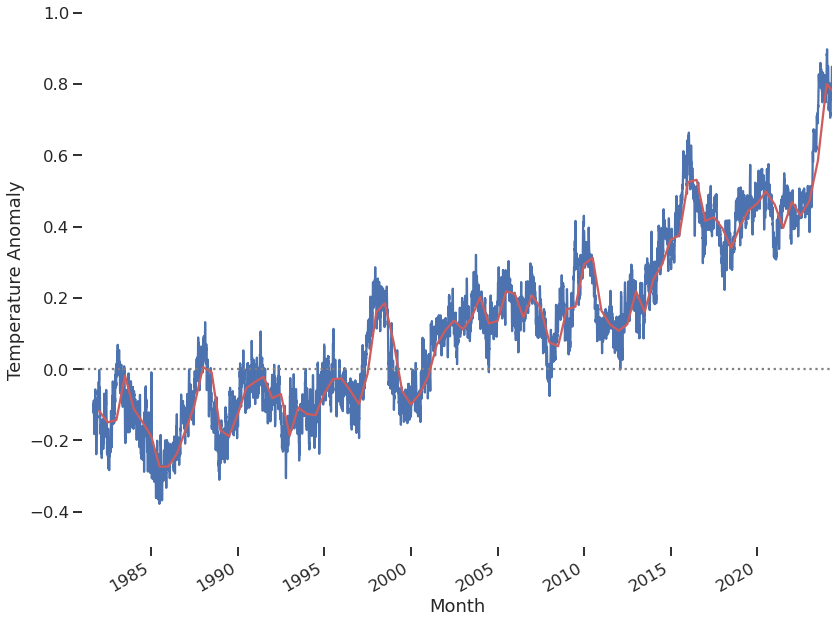

In [50]:
sns.set_theme('talk')
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(12,9))
ax = df_data_normed.set_index('date').temp.plot()
df_data_normed.set_index('date').resample('6M').mean().temp.plot(color='IndianRed', ax=ax)
plt.ylim(-0.5,1)
left = dt.date(1981, 1, 1)
right = dt.date(2024, 4, 30)
ax.set_xbound(left, right)
plt.ylabel('Temperature Anomaly')
plt.xlabel('Month')
plt.tight_layout()
ax.axhline(0, color='gray', ls='dotted')
sns.despine(left=True, bottom=True)

/tmp/ipykernel_1205286/2620837088.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_data.set_index('date').resample('6M').mean().temp.plot(color='IndianRed', ax=ax)


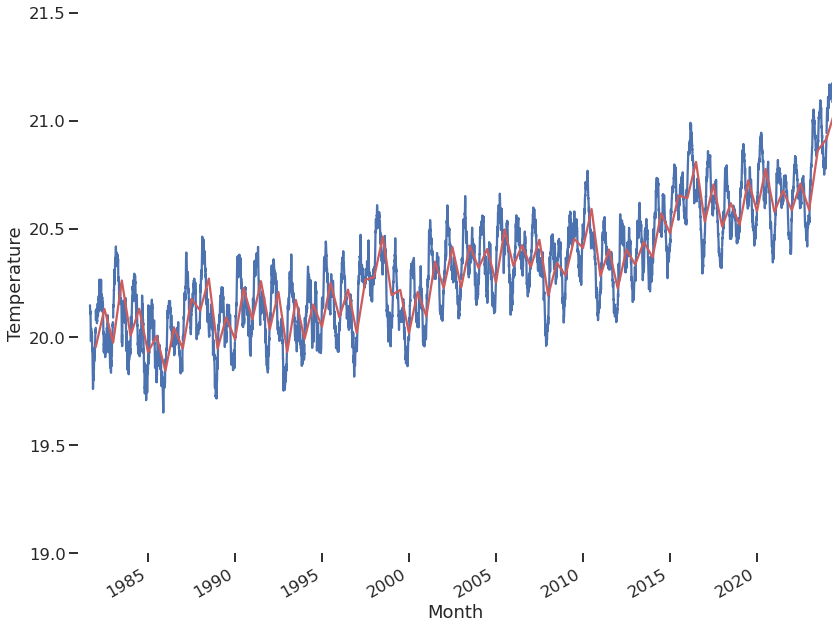

In [51]:
sns.set_theme('talk')
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(12,9))
ax = df_data.set_index('date').temp.plot()
df_data.set_index('date').resample('6M').mean().temp.plot(color='IndianRed', ax=ax)

left = dt.date(1981, 1, 1)
right = dt.date(2024, 4, 30)
ax.set_xbound(left, right)
plt.ylabel('Temperature')
plt.xlabel('Month')
plt.tight_layout()
#ax.axhline(0, color='gray', ls='dotted')
plt.ylim(19,21.5)
sns.despine(left=True, bottom=True)


/tmp/ipykernel_1205286/4133149306.py:6: UserWarning: The palette list has more values (44) than needed (42), which may not be intended.
  sns.lineplot(data=df_data_normed[~df_data_normed.temp.isnull()].query("year<2023"), x='date2000',y='temp', hue='year', palette=[str(i) for i in np.flipud(np.linspace(0.5,0.9,len(df_data.year.unique())))],
/home/magnusp/software/miniconda3/envs/analysis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/magnusp/software/miniconda3/envs/analysis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = gr

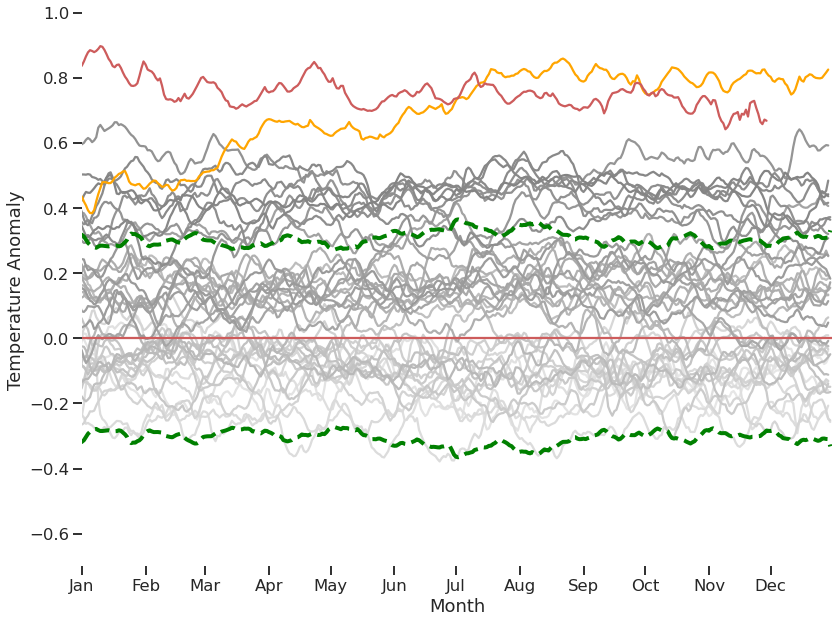

In [52]:
sns.set_theme('talk')
sns.set_style('ticks')


fig, ax = plt.subplots(figsize=(12,9))
sns.lineplot(data=df_data_normed[~df_data_normed.temp.isnull()].query("year<2023"), x='date2000',y='temp', hue='year', palette=[str(i) for i in np.flipud(np.linspace(0.5,0.9,len(df_data.year.unique())))],
            ax=ax)
#sns.lineplot(data=df_data_mean, x='day',y='temp', ax=ax, color='Green', lw=2)

sns.lineplot(data=df_data_mean.eval('twosig_pos = twosig'), x='date2000',y='twosig_pos', ax=ax, ls='--', color='Green', lw=4)
sns.lineplot(data=df_data_mean.eval('twosig_neg = -1*twosig'), x='date2000',y='twosig_neg', ax=ax, ls='--', color='Green', lw=4)
sns.lineplot(data=df_data_normed[~df_data_normed.temp.isnull()].query("year==2023"), x='date2000',y='temp', color='Orange')

sns.lineplot(data=df_data_normed[~df_data_normed.temp.isnull()].query("year>=2024"), x='date2000',y='temp', color='IndianRed')
ax.axhline(0,c='IndianRed')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.legend([], frameon=False)

#plt.xlim('2000-01-01','2000-12-31')
plt.ylim(-0.7,1)
left = dt.date(2000, 1, 1)
right = dt.date(2000, 12, 31)
ax.set_xbound(left, right)
plt.ylabel('Temperature Anomaly')
plt.xlabel('Month')
plt.tight_layout()
sns.despine(left=True, bottom=True)

/home/magnusp/software/miniconda3/envs/analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


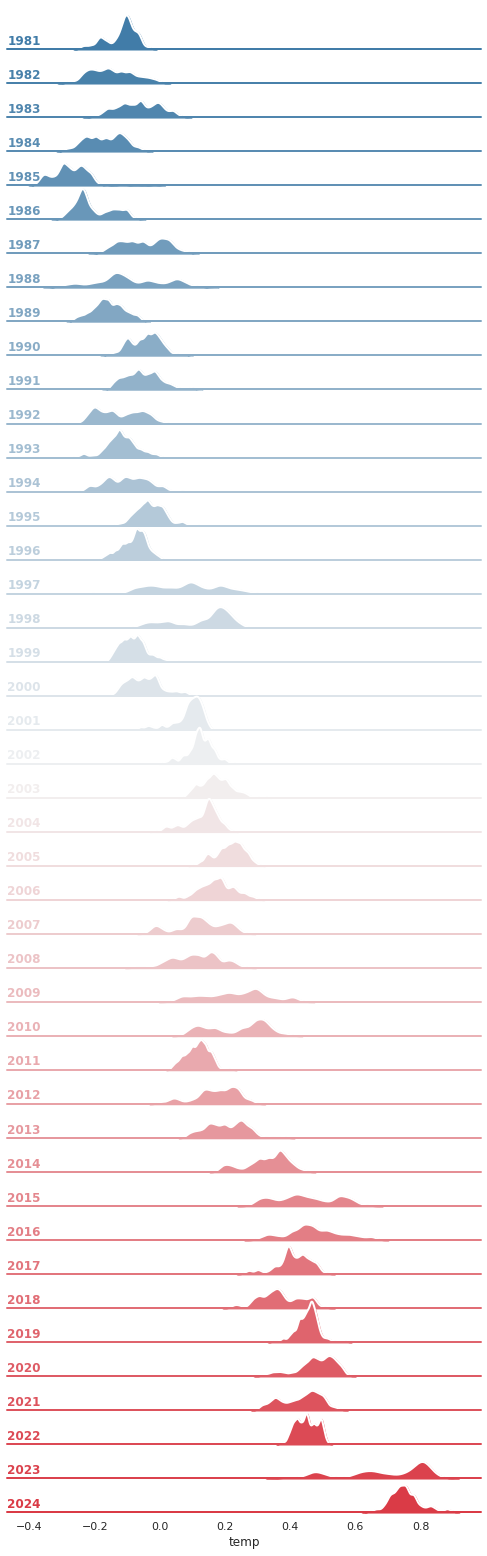

In [53]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
#pal = sns.cubehelix_palette(len(df_data_normed.year.unique()), rot=-.25, light=.7)
pal = sns.diverging_palette(240, 10, n=len(df_data_normed.year.unique())) # blue to red
g = sns.FacetGrid(df_data_normed, row="year", hue="year", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "temp",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5,
     )

g.map(sns.kdeplot, "temp", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "temp")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.2)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)